In [1]:
## import dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd

import sys
sys.path.append("./STalign/")

import torch
import plotly
import requests

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)


from STalign import STalign

0.0
1.0
(3, 2000, 1809)


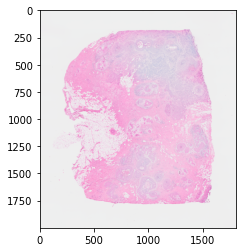

In [2]:
# Target is H&E staining image
image_file = "../Visium/spatial/tissue_hires_image.png"
V = plt.imread(image_file)

# Normalize image
Jnorm = STalign.normalize(V)
print(Jnorm.min())
print(Jnorm.max())

fig,ax = plt.subplots()
ax.imshow(Jnorm)

#Transpose Image to a np array
J = Jnorm.transpose(2,0,1)
print(J.shape)

YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
extentJ = STalign.extent_from_x((YJ,XJ))

0 of 167780
10000 of 167780
20000 of 167780
30000 of 167780
40000 of 167780
50000 of 167780
60000 of 167780
70000 of 167780
80000 of 167780
90000 of 167780
100000 of 167780
110000 of 167780
120000 of 167780
130000 of 167780
140000 of 167780
150000 of 167780
160000 of 167780
167779 of 167780


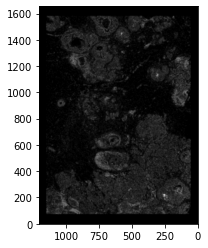

In [3]:
# Single cell data to be aligned
fname = './Xenium_register/outs_rep1/cells.csv.gz'
df = pd.read_csv(fname)
df.head()
# get cell centroid coordinates
# flip x and y to make it align
xI = np.array(df['y_centroid'])
yI = np.array(df['x_centroid'])

# rasterize and plot
XI,YI,I,fig = STalign.rasterize(xI, yI, dx=5)
ax = fig.axes[0]
ax.invert_yaxis()
ax.invert_xaxis()

I = np.vstack((I, I, I)) # make into 3xNxM
# normalize
# Normalize image
I = STalign.normalize(I)

In [4]:
#np.savez('./Xenium_register/Xenium_to_VisiumHE', x=XI,y=YI,I=I)
#np.savez('./Xenium_register/Visium', x=XJ,y=YJ,I=J)
#python point_annotator.py Xenium_register/Xenium_to_VisiumHE.npz Xenium_register/Visium.npz

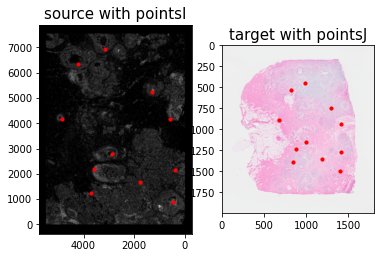

In [4]:
extentI_tx = STalign.extent_from_x((YI,XI))

## Read landmarks and plot

# read from file
pointsIlist_tx = np.load('./xenium_rep1_to_visium/points/Xenium_to_VisiumHE_points.npy', allow_pickle=True).tolist()
pointsJlist_tx = np.load('./xenium_rep1_to_visium/points/Visium_points.npy', allow_pickle=True).tolist()

# convert to array
pointsI_tx = []
pointsJ_tx = []

for i in pointsIlist_tx.keys():
    for j in range(len(pointsIlist_tx[i])):
        pointsI_tx.append([pointsIlist_tx[i][j][1], pointsIlist_tx[i][j][0]])
for i in pointsJlist_tx.keys():
    for j in range(len(pointsJlist_tx[i])):
        pointsJ_tx.append([pointsJlist_tx[i][j][1], pointsJlist_tx[i][j][0]])

pointsI_tx = np.array(pointsI_tx)
pointsJ_tx = np.array(pointsJ_tx)
# plot

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI_tx)
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)


ax[0].scatter(pointsI_tx[:,1],pointsI_tx[:,0], c='red', s=10)
ax[1].scatter(pointsJ_tx[:,1],pointsJ_tx[:,0], c='red', s=10)


ax[0].set_title('source with pointsI', fontsize=15)
ax[1].set_title('target with pointsJ', fontsize=15)

# invert only rasterized image
ax[0].invert_yaxis()
ax[0].invert_xaxis()

(2, 167780)


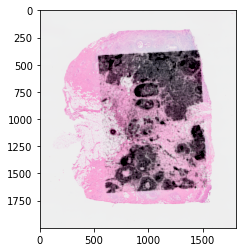

In [6]:
# compute initial affine transformation and show points
L_tx,T_tx = STalign.L_T_from_points(pointsJ_tx,pointsI_tx)
# note points are as y,x
affine = np.dot(np.linalg.inv(L_tx), [yI- T_tx[0] ,xI - T_tx[1]])
print(affine.shape)
xIaffine = V.shape[0] - affine[0,:]
yIaffine = affine[1,:]

# plot
fig,ax = plt.subplots()
ax.scatter(yIaffine,xIaffine,s=1,alpha=0.01,c='Black')
ax.imshow((J).transpose(1,2,0))

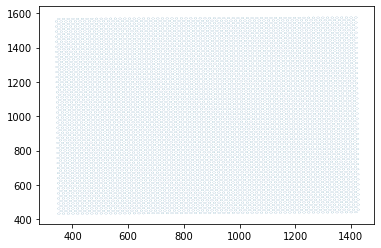

In [30]:
# Single cell data to be aligned
fname_visium_poly = './Xenium_register/Images/Visium_polygons.csv'
df_poly = pd.read_csv(fname_visium_poly)
#df_poly
# get cell centroid coordinates
# flip x and y to make it align
X_poly = np.array(df_poly['x'])
Y_poly = np.array(df_poly['y'])
fig,ax = plt.subplots()
ax.scatter(X_poly,Y_poly,s=0.05,alpha=0.01)

(2, 504192)


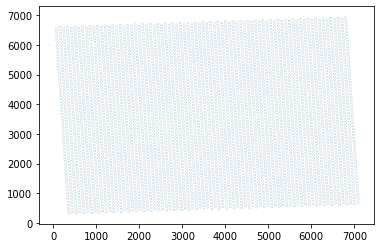

In [31]:
L_poly,T_poly = STalign.L_T_from_points(pointsI_tx,pointsJ_tx)
affine = np.dot(np.linalg.inv(L_poly), [Y_poly - T_poly[0], X_poly - T_poly[1]])
print(affine.shape)
xpoly_affine = affine[0,:] 
ypoly_affine = affine[1,:]
fig,ax = plt.subplots()
ax.scatter(xpoly_affine,ypoly_affine,s=0.05,alpha=0.01)

df_visium_aligned = pd.DataFrame({"visium_to_xenium_aligned_x": xpoly_affine,"visium_to_xenium_aligned_y": ypoly_affine})
results = pd.concat([df_poly, df_visium_aligned], axis=1)

results.to_csv('./Aligned_Xe_rep1/Visium_polygons_to_Xenium.csv.gz',
               compression='gzip')


/projectnb/rd-spat/HOME/junxiang/Image_Registration/./STalign/STalign/STalign.py:1636: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
/projectnb/rd-spat/HOME/junxiang/Image_Registration/./STalign/STalign/STalign.py:1649: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


Text(0.5, 1.0, 'target')

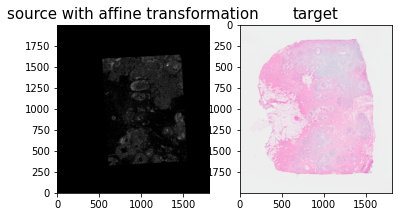

In [7]:
# Keep compute initial affine transformation for LDDMM(image fields)
# **Note the change of landmark order!!!
L_tx,T_tx = STalign.L_T_from_points(pointsI_tx,pointsJ_tx)
A_tx = STalign.to_A(torch.tensor(L_tx),torch.tensor(T_tx))
# compute initial affine transformation from points
AI_tx= STalign.transform_image_atlas_with_A(A_tx, [YI,XI], I, [YJ,XJ])

fig,ax = plt.subplots(1,2)

if AI_tx.is_cuda:
    ax[0].imshow((AI_tx.cpu().permute(1,2,0).squeeze()), extent=extentJ)
else:
    ax[0].imshow((AI_tx.permute(1,2,0).squeeze()), extent=extentJ)
    
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)

ax[0].set_title('source with affine transformation', fontsize=15)
ax[0].invert_yaxis()
ax[1].set_title('target', fontsize=15)

/projectnb/rd-spat/HOME/junxiang/Image_Registration/./STalign/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/projectnb/rd-spat/HOME/junxiang/Image_Registration/./STalign/STalign/STalign.py:1294: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


CPU times: user 3min 40s, sys: 6.09 s, total: 3min 46s
Wall time: 3min 47s


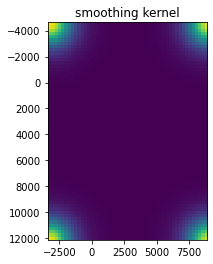

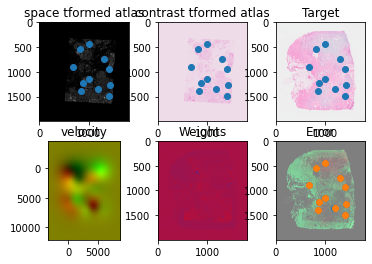

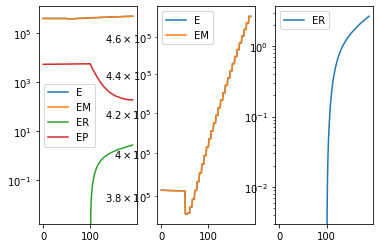

In [15]:
%%time
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {'L':L_tx,'T':T_tx,
          'niter': 200,
          'pointsI': pointsI_tx,
          'pointsJ': pointsJ_tx,
          'device': device,
          'sigmaP': 2e-1,
          'sigmaM': 0.18,
          'sigmaB': 0.18,
          'sigmaA': 0.18,
          'diffeo_start' : 100,
          'epL': 5e-11,
          'epT': 5e-4,
          'epV': 5e1
          }

A_tx,v_tx,xv_tx = STalign.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

/projectnb/rd-spat/HOME/junxiang/Image_Registration/./STalign/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


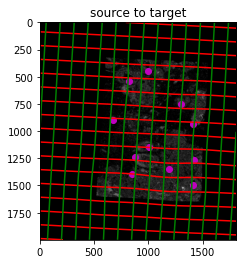

In [16]:
# apply transform
phii_tx = STalign.build_transform(xv_tx,v_tx,A_tx,XJ=[YJ,XJ],direction='b')
phiI_tx = STalign.transform_image_atlas_to_target(xv_tx,v_tx,A_tx,[YI,XI],I,[YJ,XJ])
phiipointsI_tx = STalign.transform_points_atlas_to_target(xv_tx,v_tx,A_tx,pointsI_tx)
# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,750)

if phii_tx.is_cuda:
    ax.contour(XJ,YJ,phii_tx[...,0].cpu(),colors='r',linestyles='-',levels=levels)
    ax.contour(XJ,YJ,phii_tx[...,1].cpu(),colors='g',linestyles='-',levels=levels)
else:
    ax.contour(XJ,YJ,phii_tx[...,0],colors='r',linestyles='-',levels=levels)
    ax.contour(XJ,YJ,phii_tx[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')

if phiI_tx.is_cuda:
    ax.imshow(phiI_tx.cpu().permute(1,2,0)/torch.max(phiI_tx.cpu()),extent=extentJ)
else:
    ax.imshow(phiI_tx.permute(1,2,0)/torch.max(phiI_tx),extent=extentJ)

if phiipointsI_tx.is_cuda:
    ax.scatter(phiipointsI_tx[:,1].cpu().detach(),phiipointsI_tx[:,0].cpu().detach(),c="m")
else:
    ax.scatter(phiipointsI_tx[:,1].detach(),phiipointsI_tx[:,0].detach(),c="m")

Text(0.5, 1.0, 'After alignment aligned source and target with aligned pointsI and pointsJ')

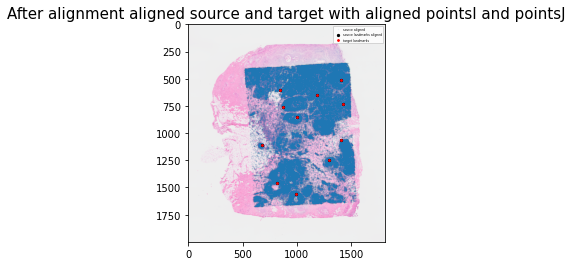

In [18]:
# apply transform to original points
tpointsI_tx= STalign.transform_points_atlas_to_target(xv_tx,v_tx,A_tx, np.stack([yI, xI], 1))

# switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI_tx[:,1]
yI_LDDMM = V.shape[0] - tpointsI_tx[:,0]

if phiipointsI_tx.is_cuda:
    landmarks_tx_x = phiipointsI_tx[:,1].cpu().detach()
    landmarks_tx_y = V.shape[0] - phiipointsI_tx[:,0].cpu().detach()
else:
    landmarks_tx_x = phiipointsI_tx[:,1].cpu().detach()
    landmarks_tx_y = V.shape[0] - phiipointsI_tx[:,0].cpu().detach()

landmarks_HE_x = pointsJ_tx[:,1]
landmarks_HE_y = V.shape[0] - pointsJ_tx[:,0]

# plot results
fig,ax = plt.subplots()

ax.imshow((J).transpose(1,2,0),extent=extentJ)

if tpointsI_tx.is_cuda:
    ax.scatter(xI_LDDMM.cpu(),yI_LDDMM.cpu(),s=0.1,alpha=0.1, label = 'source aligned')
else:
    ax.scatter(xI_LDDMM,yI_LDDMM,s=0.1,alpha=0.1, label = 'source aligned')

ax.scatter(landmarks_tx_x,landmarks_tx_y,c="black", label='source landmarks aligned', s=5)
ax.scatter(landmarks_HE_x,landmarks_HE_y, c='red', label='target landmarks', s=3)
ax.set_aspect('equal')
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=3)

ax.set_title('After alignment aligned source and target with aligned pointsI and pointsJ', fontsize=15)
#plt.savefig('Xenium_to_Visium_HE_rep1.png',dpi = 2000)

In [19]:
df3 = pd.DataFrame(

        {

            "aligned_x": xI_LDDMM.cpu(),

            "aligned_y": yI_LDDMM.cpu(),

        }
)
results = pd.concat([df, df3], axis=1)
results.to_csv('./xenium_rep1_to_visium/Xenium_Rep1_STalign_to_VisiumHE.csv')
##Note the transcripts will be aligned using the same Deformation field